In [ ]:
import scipy.stats as scs
import pandas as pd 
import numpy as np                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

## Define Function for generating data 

In [ ]:
def generate_data(N_A, N_B, p_A, p_B, control_label = 'A', treatment_label = 'B'):
   data = []
   N = N_A + N_B # total number of rows in df
    # initiate bernoulli distribution  
   group_bern = scs.bernoulli(N_A/ (N_A + N_B)) # the discrete RV gourp_bern will have 50% chance being 1, and 50% chance being 0
    # pass in parameter 'p'- the probability of a single success - aka. a customer is converted
   A_bern = scs.bernoulli(p_A)
   B_bern = scs.bernoulli(p_B)

   for idx in range(N):
     row = {}
     row['group'] = group_bern.rvs()  # .rvs() -> generate a sequence of random variates
     # assign convertion value based on each group's predefined CTR
     if row['group'] == 0:
      row['converted'] = A_bern.rvs()
     else:
      row['converted'] = B_bern.rvs()
      # concatenate rows and convert into dataframe
     data.append(row)
   df = pd.DataFrame(data)

      # transform group label of 0s & 1s to control & treatment 
   df['group'] = df['group'].apply(
       lambda x: control_label if x == 0 else treatment_label)
   return df


   """Returns a pandas dataframe with fake site visit data
    
    Parameters:
        N_A (int): sample size for control group
        N_B (int): sample size for treatment group
            Note: final sample size may not match N_A provided because the
            group at each row is chosen at random (50/50).
        p_A (float): conversion rate; convertion rate of control group
        p_B (float): conversion rate; convertion rate of treatment group
        control_label (str)
        treatment_label (str)
    """







## Generate data and summarize result 

In [ ]:
bcr = 0.20 # baseline conversion rate - equal to the conversion rate of the control group 
diff_hat = 0.01 # 1% increase bring by new web design that we want our test to confirm 
p_B = bcr + diff_hat # treatment group conversion rate 
p_A = bcr
N_A = 1000
N_B = 1000
print (p_A, p_B, N_A, N_B)

0.2 0.21000000000000002 1000 1000


In [ ]:
  ab_data = generate_data(N_A, N_B, p_A, p_B)
ab_data.head(2000)

,group,converted
0,A,0
1,A,1
2,A,1
3,B,0
4,B,0
...,...,...
1995,A,0
1996,B,0
1997,B,0
1998,B,0


Summary of the data 

In [ ]:
df_summary = ab_data.pivot_table(
    index ='group', values = 'converted', aggfunc = np.sum)
df_summary['total'] = ab_data.pivot_table(
    index ='group', values = 'converted', aggfunc = lambda x: len(x))
df_summary['CTR'] = ab_data.pivot_table(values = 'converted', index = 'group')
df_summary

,converted,total,CTR
group,,,
A,225,989,0.227503
B,206,1011,0.203759


The difference of CTR between two group is x, more than 0.01 that we wanted to confirm previously.  

## Plotting Binominal distribution of two groups

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as scs
#from scs import pooled_SE, confidence_interval, ab_dist, p_val, z_val

plt.style.use('ggplot')

In [ ]:
A_converted, B_converted = df_summary['converted']['A'], df_summary['converted']['B']
A_total, B_total = df_summary['total']['A'], df_summary['total']['B']
p_A, p_B = df_summary['CTR']['A'], df_summary['CTR']['B']

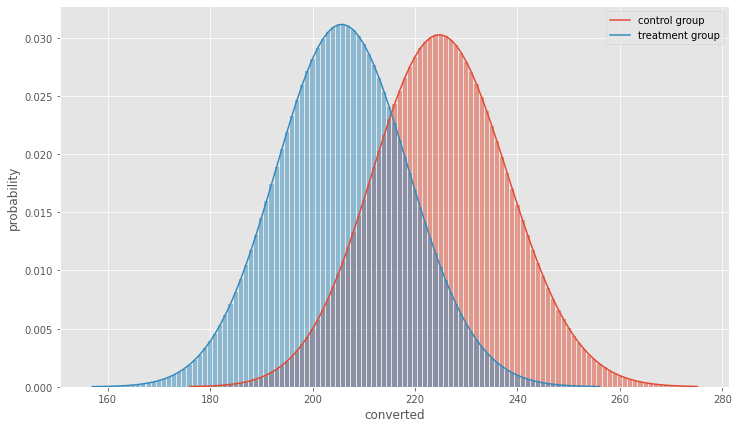

In [ ]:
fig, ax = plt.subplots(figsize = (12,7))
xA = np.linspace(A_converted -49, A_converted + 50, 100)
yA = scs.binom(A_total, p_A).pmf(xA)
xB = np.linspace(B_converted -49, B_converted + 50, 100)
yB = scs.binom(B_total, p_B).pmf(xB)

ax.bar(xA, yA, alpha = 0.5)
ax.bar(xB, yB, alpha = 0.5)

plt.plot(xA, yA, label = 'control group')
plt.plot(xB, yB, label = 'treatment group')
plt.xlabel('converted')
plt.ylabel('probability')
plt.legend()

## Plotting Normal distribution of two groups

Text(0, 0.5, 'PDF')

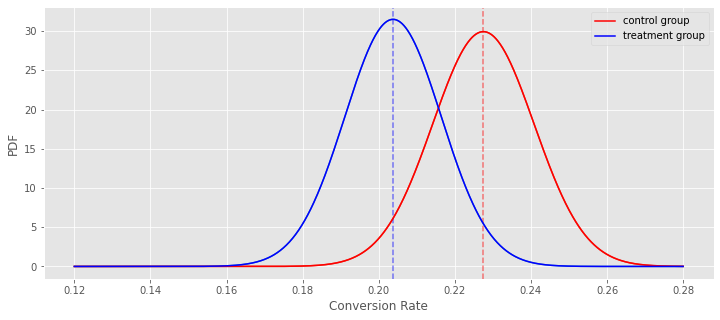

In [ ]:
# standard error of the mean for both groups
SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(A_total)
SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(B_total)
# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,5))
x = np.linspace(.12, .28, 1000)
yA = scs.norm(p_A, SE_A).pdf(x)
ax.plot(x, yA)
ax.axvline(x=p_A, c='red', alpha=0.5, linestyle='--')
yB = scs.norm(p_B, SE_B).pdf(x)
ax.plot(x, yB)
ax.axvline(x=p_B, c='blue', alpha=0.5, linestyle='--')
plt.plot(x, yA, label = 'control group', c = 'red')
plt.plot(x, yB, label = 'treatment group', c = 'blue')
plt.legend()
plt.xlabel('Conversion Rate')
plt.ylabel('PDF')

## Plotting Function

In [ ]:
import numpy as np
import scipy.stats as scs


def pooled_prob(N_A, N_B, X_A, X_B):
    """Returns pooled probability for two samples"""
    return (X_A + X_B) / (N_A + N_B)


def pooled_SE(N_A, N_B, X_A, X_B):
    """Returns the pooled standard error for two samples"""
    p_hat = pooled_prob(N_A, N_B, X_A, X_B)
    SE = np.sqrt(p_hat * (1 - p_hat) * (1 / N_A + 1 / N_B))
    return SE


def confidence_interval(sample_mean=0, sample_std=1, sample_size=1,
                        sig_level=0.05):
    """Returns the confidence interval as a tuple"""
    z = z_val(sig_level)

    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)

    return (left, right)


def z_val(sig_level=0.05, two_tailed=True):
    """Returns the z value for a given significance level"""
    z_dist = scs.norm()
    if two_tailed:
        sig_level = sig_level/2
        area = 1 - sig_level
    else:
        area = 1 - sig_level

    z = z_dist.ppf(area)

    return z


def ab_dist(stderr, d_hat=0, group_type='control'):
    """Returns a distribution object depending on group type
    Examples:
    Parameters:
        stderr (float): pooled standard error of two independent samples
        d_hat (float): the mean difference between two independent samples
        group_type (string): 'control' and 'test' are supported
    Returns:
        dist (scipy.stats distribution object)
    """
    if group_type == 'control':
        sample_mean = 0

    elif group_type == 'test':
        sample_mean = d_hat

    # create a normal distribution which is dependent on mean and std dev
    dist = scs.norm(sample_mean, stderr)
    return dist


def min_sample_size(bcr, mde, power=0.8, sig_level=0.05):
    """Returns the minimum sample size to set up a split test
    Arguments:
        bcr (float): probability of success for control, sometimes
        referred to as baseline conversion rate
        mde (float): minimum change in measurement between control
        group and test group if alternative hypothesis is true, sometimes
        referred to as minimum detectable effect
        power (float): probability of rejecting the null hypothesis when the
        null hypothesis is false, typically 0.8
        sig_level (float): significance level often denoted as alpha,
        typically 0.05
    Returns:
        min_N: minimum sample size (float)
    References:
        Stanford lecture on sample sizes
        http://statweb.stanford.edu/~susan/courses/s141/hopower.pdf
    """
    # standard normal distribution to determine z-values
    standard_norm = scs.norm(0, 1)

    # find Z_beta from desired power
    Z_beta = standard_norm.ppf(power)

    # find Z_alpha
    Z_alpha = standard_norm.ppf(1-sig_level/2)

    # average of probabilities from both groups
    pooled_prob = (bcr + bcr+mde) / 2

    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2
             / mde**2)

    return min_N

# Two tailed or one tailed ???
def p_val(N_A, N_B, p_A, p_B):
    """Returns the p-value for an A/B test"""
    return scs.binom(N_A, p_A).pmf(p_B * N_B)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
import scipy.stats as scs

#from .stats import pooled_SE, confidence_interval, ab_dist, p_val, z_val

plt.style.use('ggplot')


def plot_norm_dist(ax, mu, std, with_CI=False, sig_level=0.05, label=None):
    """Adds a normal distribution to the axes provided
    Example:
        plot_norm_dist(ax, 0, 1)  # plots a standard normal distribution
    Parameters:
        ax (matplotlib axes)
        mu (float): mean of the normal distribution
        std (float): standard deviation of the normal distribution
    Returns:
        None: the function adds a plot to the axes object provided
    """
    x = np.linspace(mu - 12 * std, mu + 12 * std, 1000)
    y = scs.norm(mu, std).pdf(x)
    ax.plot(x, y, label=label)

    if with_CI:
        plot_CI(ax, mu, std, sig_level=sig_level)


def plot_binom_dist(ax, n, p, label=None):
    """Adds a binomial distribution to the axes provided
    Example:
        plot_binom_dist(ax, 0, 1)  # plots a standard normal distribution
    Parameters:
        ax (matplotlib axes)
        mu (float): mean of the normal distribution
        sig (float): standard deviation of the normal distribution
    Returns:
        None: the function adds a plot to the axes object provided
    """
    x = np.linspace(0, n, n+1)
    y = scs.binom(n, p).pmf(x)
    ax.plot(x, y, label=label)


def plot_CI(ax, mu, s, sig_level=0.05, color='grey'):
    """Calculates the two-tailed confidence interval and adds the plot to
    an axes object.
    Example:
        plot_CI(ax, mu=0, s=stderr, sig_level=0.05)
    Parameters:
        ax (matplotlib axes)
        mu (float): mean
        s (float): standard deviation
    Returns:
        None: the function adds a plot to the axes object provided
    """
    left, right = confidence_interval(sample_mean=mu, sample_std=s,
                                      sig_level=sig_level)
    ax.axvline(left, c=color, linestyle='--', alpha=0.5)
    ax.axvline(right, c=color, linestyle='--', alpha=0.5)


def plot_null(ax, stderr):
    """Plots the null hypothesis distribution where if there is no real change,
    the distribution of the differences between the test and the control groups
    will be normally distributed.
    The confidence band is also plotted.
    Example:
        plot_null(ax, stderr)
    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group
    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, 0, stderr, label="Null")
    #plot_CI(ax, mu=0, s=stderr, sig_level=0.05)


def plot_alt(ax, stderr, d_hat):
    """Plots the alternative hypothesis distribution where if there is a real
    change, the distribution of the differences between the test and the
    control groups will be normally distributed and centered around d_hat
    The confidence band is also plotted.
    Example:
        plot_alt(ax, stderr, d_hat=0.025)
    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group
    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, d_hat, stderr, label="Alternative")


def abplot(N_A, N_B, bcr, d_hat, sig_level=0.05, show_power=False,
           show_alpha=False, show_beta=False, show_p_value=False,
           show_legend=True):
    """Example plot of AB test
    Example:
        abplot(n=4000, bcr=0.11, d_hat=0.03)
    Parameters:
        n (int): total sample size for both control and test groups (N_A + N_B)
        bcr (float): base conversion rate; conversion rate of control
        d_hat: difference in conversion rate between the control and test
            groups, sometimes referred to as **minimal detectable effect** when
            calculating minimum sample size or **lift** when discussing
            positive improvement desired from launching a change.
    Returns:
        None: the function plots an AB test as two distributions for
        visualization purposes
    """
    # create a plot object
    fig, ax = plt.subplots(figsize=(12, 6))

    # define parameters to find pooled standard error
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = pooled_SE(N_A, N_B, X_A, X_B)

    # plot the distribution of the null and alternative hypothesis
    plot_null(ax, stderr)
    plot_alt(ax, stderr, d_hat)

    # set extent of plot area
    #ax.set_xlim(-8 * stderr, 8 * stderr)
    ax.set_xlim(-0.1, .125 )

    ax.axvline(0, c='red', alpha=0.5, linestyle='--')
    ax.axvline(d_hat, c='blue', alpha=0.5, linestyle='--')

    # shade areas according to user input
    if show_power:
        show_area(ax, d_hat, stderr, sig_level, area_type='power')
    if show_alpha:
        show_area(ax, d_hat, stderr, sig_level, area_type='alpha')
    if show_beta:
        show_area(ax, d_hat, stderr, sig_level, area_type='beta')

    # show p_value based on the binomial distributions for the two groups
    if show_p_value:
        null = ab_dist(stderr, 'control')
        p_value = p_val(N_A, N_B, bcr, bcr+d_hat)
        ax.text(3 * stderr, null.pdf(0),
                'p-value = {0:.3f}'.format(p_value),
                fontsize=12, ha='left')

    # option to show legend
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()


def show_area(ax, d_hat, stderr, sig_level, area_type='power'):
    """Fill between upper significance boundary and distribution for
    alternative hypothesis
    """
    left, right = confidence_interval(sample_mean=0, sample_std=stderr,
                                      sig_level=sig_level)
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    null = ab_dist(stderr, 'control')
    alternative = ab_dist(stderr, d_hat, 'test')

    # if area_type is power
    # Fill between upper significance boundary and distribution for alternative
    # hypothesis
    if area_type == 'power':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha= 0.25 ,
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'power = {0:.3f}'.format(1 - alternative.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is alpha
    # Fill between upper significance boundary and distribution for null
    # hypothesis
    if area_type == 'alpha':
        ax.fill_between(x, 0, null.pdf(x), color='green', alpha= 0.25 ,
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'alpha = {0:.3f}'.format(1 - null.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is beta
    # Fill between distribution for alternative hypothesis and upper
    # significance boundary
    if area_type == 'beta':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha= 0.25 ,
                        where=(x < right))
        ax.text(-3 * stderr, null.pdf(0),
                'beta = {0:.3f}'.format(alternative.cdf(right)),
                fontsize=12, ha='right', color='k')


def zplot(area=0.95, two_tailed=True, align_right=False):
    """Plots a z distribution with common annotations
    Example:
        zplot(area=0.95)
        zplot(area=0.80, two_tailed=False, align_right=True)
    Parameters:
        area (float): The area under the standard normal distribution curve.
        align (str): The area under the curve can be aligned to the center
            (default) or to the left.
    Returns:
        None: A plot of the normal distribution with annotations showing the
        area under the curve and the boundaries of the area.
    """
    # create plot object
    fig = plt.figure(figsize=(12, 6))
    ax = fig.subplots()
    # create normal distribution
    norm = scs.norm()
    # create data points to plot
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x)

    ax.plot(x, y)

    # code to fill areas
    # for two-tailed tests
    if two_tailed:
        left = norm.ppf(0.5 - area / 2)
        right = norm.ppf(0.5 + area / 2)
        ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
        ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')

        ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                        where=(x > left) & (x < right))
        plt.xlabel('z')
        plt.ylabel('PDF')
        plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), fontsize=12,
                 rotation=90, va="bottom", ha="right")
        plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                 fontsize=12, rotation=90, va="bottom", ha="left")
    # for one-tailed tests
    else:
        # align the area to the right
        if align_right:
            left = norm.ppf(1-area)
            ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                            where=x > left)
            plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left),
                     fontsize=12, rotation=90, va="bottom", ha="right")
        # align the area to the left
        else:
            right = norm.ppf(area)
            ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                            where=x < right)
            plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                     fontsize=12, rotation=90, va="bottom", ha="left")

    # annotate the shaded area
    plt.text(0, 0.1, "shaded area = {0:.3f}".format(area), fontsize=12,
             ha='center')
    # axis labels
    plt.xlabel('z')
    plt.ylabel('PDF')

    plt.show()


def abplot_CI_bars(N, X, sig_level=0.05, dmin=None):
    """Returns a confidence interval bar plot for multivariate tests
    Parameters:
        N (list or tuple): sample size for all groups
        X (list or tuple): number of conversions for each variant
        sig_level (float): significance level
        dmin (float): minimum desired lift; a red and green dashed lines are
            shown on the plot if dmin is provided.
    Returns:
        None: A plot of the confidence interval bars is returned inline.
    """

    # initiate plot object
    fig, ax = plt.subplots(figsize=(12, 3))

    # get control group values
    N_A = N[0]
    X_A = X[0]

    # initiate containers for standard error and differences
    SE = []
    d = []
    # iterate through X and N and calculate d and SE
    for idx in range(1, len(N)):
        X_B = X[idx]
        N_B = N[idx]
        d.append(X_B / N_B - X_A / N_A)
        SE.append(pooled_SE(N_A, N_B, X_A, X_B))

    # convert to numpy arrays
    SE = np.array(SE)
    d = np.array(d)

    y = np.arange(len(N)-1)

    # get z value
    z = z_val(sig_level)
    # confidence interval values
    ci = SE * z

    # bar to represent the confidence interval
    ax.hlines(y, d-ci, d+ci, color='blue', alpha=0.35, lw=10, zorder=1)
    # marker for the mean
    ax.scatter(d, y, s=300, marker='|', lw=10, color='magenta', zorder=2)

    # vertical line to represent 0
    ax.axvline(0, c='grey', linestyle='-')

    # plot veritcal dashed lines if dmin is provided
    if dmin is not None:
        ax.axvline(-dmin, c='red', linestyle='--', alpha=0.75)
        ax.axvline(dmin, c='green', linestyle='--', alpha=0.75)

    # invert y axis to show variant 1 at the top
    ax.invert_yaxis()
    # label variants on y axis
    labels = ['variant{}'.format(idx+1) for idx in range(len(N)-1)]
    plt.yticks(np.arange(len(N)-1), labels)


def funnel_CI_plot(A, B, sig_level=0.05):
    """Returns a confidence interval bar plot for multivariate tests
    Parameters:
        A (list of tuples): (sample size, conversions) for control group funnel
        B (list of tuples): (sample size, conversions) for test group funnel
        sig_level (float): significance level
    Returns:
        None: A plot of the confidence interval bars is returned inline.
    """

    # initiate plot object
    fig, ax = plt.subplots(figsize=(12, 3))

    # initiate containers for standard error and differences
    SE = []
    d = []
    # iterate through X and N and calculate d and SE
    for idx in range(len(A)):
        X_A = A[idx][1]
        N_A = A[idx][0]
        X_B = B[idx][1]
        N_B = B[idx][0]
        d.append(X_B / N_B - X_A / N_A)
        SE.append(pooled_SE(N_A, N_B, X_A, X_B))

    # convert to numpy arrays
    SE = np.array(SE)
    d = np.array(d)
    print(d)

    y = np.arange(len(A))

    # get z value
    z = z_val(sig_level)
    # confidence interval values
    ci = SE * z

    # bar to represent the confidence interval
    ax.hlines(y, d-ci, d+ci, color='blue', alpha=0.35, lw=10, zorder=1)
    # marker for the mean
    ax.scatter(d, y, s=300, marker='|', lw=10, color='magenta', zorder=2)

    # vertical line to represent 0
    ax.axvline(0, c='grey', linestyle='-')

    # invert y axis to show variant 1 at the top
    ax.invert_yaxis()
    # label variants on y axis
    labels = ['metric{}'.format(idx+1) for idx in range(len(A))]
    plt.yticks(np.arange(len(A)), labels)

## Plotting the Null and Alternative Hypothesis

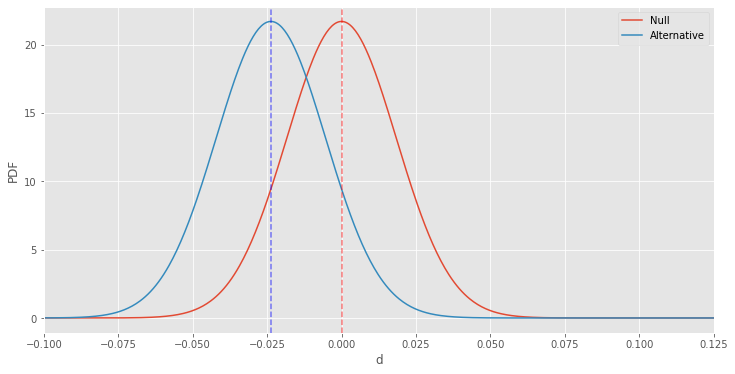

In [ ]:
# p_A is the conversion rate of the control group
# p_B is the conversion rate of the treatment group 

n = N_A + N_B
bcr = p_A
d_hat = p_B - p_A
abplot(N_A, N_B, bcr = p_A, d_hat = p_B - p_A)
# commend out 'plot_CI' from 'plot_null' 

## Plot Confidence Interval 

### code -- plot CI


In [ ]:
def plot_null(ax, stderr):
  
    plot_norm_dist(ax, 0, stderr, label="Null")
    plot_CI(ax, mu=0, s=stderr, sig_level=0.05)
def abplot(N_A, N_B, bcr, d_hat, sig_level=0.05, show_power=False,
           show_alpha=False, show_beta=False, show_p_value=False,
           show_legend=True):
    """Example plot of AB test
    Example:
        abplot(n=4000, bcr=0.11, d_hat=0.03)
    Parameters:
        n (int): total sample size for both control and test groups (N_A + N_B)
        bcr (float): base conversion rate; conversion rate of control
        d_hat: difference in conversion rate between the control and test
            groups, sometimes referred to as **minimal detectable effect** when
            calculating minimum sample size or **lift** when discussing
            positive improvement desired from launching a change.
    Returns:
        None: the function plots an AB test as two distributions for
        visualization purposes
    """
    # create a plot object
    fig, ax = plt.subplots(figsize=(12, 6))

    # define parameters to find pooled standard error
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = pooled_SE(N_A, N_B, X_A, X_B)

    # plot the distribution of the null and alternative hypothesis
    plot_null(ax, stderr)
    plot_alt(ax, stderr, d_hat)

    # set extent of plot area
    #ax.set_xlim(-8 * stderr, 8 * stderr)
    ax.set_xlim(-0.1, .125 )

    #ax.axvline(0, c='red', alpha=0.5, linestyle='--')
    #ax.axvline(d_hat, c='blue', alpha=0.5, linestyle='--')

    # shade areas according to user input
    if show_power:
        show_area(ax, d_hat, stderr, sig_level, area_type= 'power')
    if show_alpha:
        show_area(ax, d_hat, stderr, sig_level, area_type= 'alpha')
    if show_beta:
        show_area(ax, d_hat, stderr, sig_level, area_type= 'beta')

    # show p_value based on the binomial distributions for the two groups
    if show_p_value:
        null = ab_dist(stderr, 'control')
        p_value = p_val(N_A, N_B, bcr, bcr+d_hat)
        ax.text(3 * stderr, null.pdf(0),
                'p-value = {0:.3f}'.format(p_value),
                fontsize=12, ha='left')

    # option to show legend
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()


### 95% CI plot 

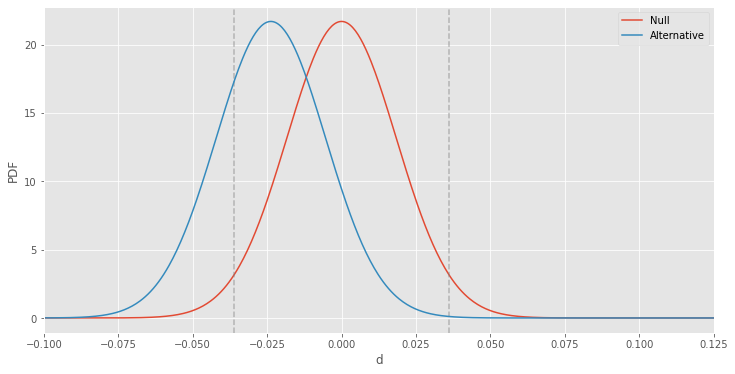

In [ ]:
abplot(N_A, N_B, bcr = p_A, d_hat = p_B - p_A)

## Z-test Statistics 

### Code -- calculate and visualize Z-test

In [ ]:
def zplot(area=0.95, two_tailed=True, align_right=False):
    """Plots a z distribution with common annotations
    Example:
        zplot(area=0.95)
        zplot(area=0.80, two_tailed=False, align_right=True)
    Parameters:
        area (float): The area under the standard normal distribution curve.
        align (str): The area under the curve can be aligned to the center
            (default) or to the left.
    Returns:
        None: A plot of the normal distribution with annotations showing the
        area under the curve and the boundaries of the area.
    """
    # create plot object
    fig = plt.figure(figsize=(12, 6))
    ax = fig.subplots()
    # create normal distribution
    norm = scs.norm()
    # create data points to plot
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x)

    ax.plot(x, y)

    # code to fill areas
    # for two-tailed tests
    if two_tailed:
        left = norm.ppf(0.5 - area / 2)
        right = norm.ppf(0.5 + area / 2)
        ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
        ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')

        ax.fill_between(x, 0, y, color='grey', alpha= 0.25,
                        where=(x > left) & (x < right))
        plt.xlabel('z')
        plt.ylabel('PDF')
        plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), fontsize=12,
                 rotation=90, va="bottom", ha="right")
        plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                 fontsize=12, rotation=90, va="bottom", ha="left")
    # for one-tailed tests
    else:
        # align the area to the right
        if align_right:
            left = norm.ppf(1 - area )
            ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha= 0.25,
                            where=x > left)
            plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left),
                     fontsize=12, rotation=90, va="bottom", ha="right")
        # align the area to the left
        else:
            right = norm.ppf(area)
            ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha= 0.25,
                            where=x < right)
            plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                     fontsize=12, rotation=90, va="bottom", ha="left")
            ax.vlines(ztest_Score, 0, norm.pdf(ztest_Score), color='green', linestyle='--')
            plt.text(ztest_Score, norm.pdf(ztest_Score), "z-test-score = {0:.3f}".format(ztest_Score),
                     fontsize=12, rotation=0, va="bottom", ha="left", color ='green')    
            #ax.vlines(norm.ppf(p_right), 0, 0.4, color='grey', linestyle='--')
            #p_value = p_val(N_A, N_B, bcr, bcr+d_hat)
            #ax.text(right, norm.pdf(right),'p-value = {0:.3f}'.format(p_value),fontsize=12, ha='left')
            #ax.vlines(p_value, 0, norm.pdf(p_value), color='grey', linestyle='--')

    # annotate the shaded area
    plt.text(0, 0.1, "shaded area = {0:.3f}".format(area), fontsize=12,
             ha='center')
    # axis labels
    plt.xlabel('z')
    plt.ylabel('PDF')
    
    plt.show()

### Z-critical value and Z-test-statistics plot 

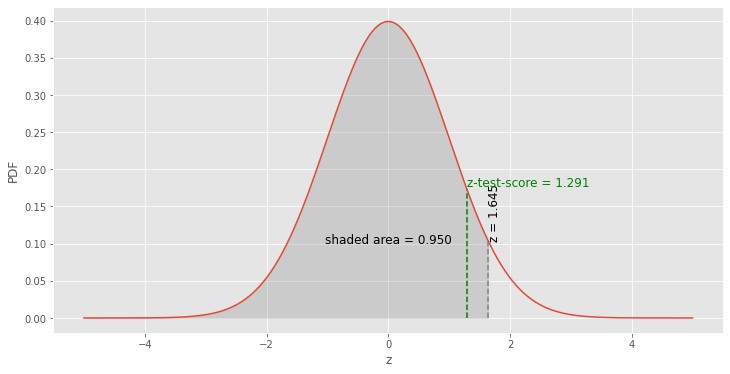

In [ ]:
zplot(area=0.95, two_tailed=False, align_right=False)

### calculate Z-test-score and p-value 

In [ ]:
from statsmodels.stats.proportion import proportions_ztest
N_A1 = N_A*p_A
N_B1 = N_B*p_B
count = np.array ([N_B1, N_A1])
nobs = np.array ([N_A,N_B])
ztest_Score, p_value = proportions_ztest(count, nobs, alternative = 'larger')
ztest_Score, p_value

(1.2909845725498592, 0.9016454864304378)

## Plot Statistical Power 

### code - plot statistical power

In [ ]:
def show_area(ax, d_hat, stderr, sig_level, area_type='power'):
    """Fill between upper significance boundary and distribution for
    alternative hypothesis
    """
    left, right = confidence_interval(sample_mean=0, sample_std=stderr,
                                      sig_level=sig_level)
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    null = ab_dist(stderr, 'control')
    alternative = ab_dist(stderr, d_hat, 'test')

    # if area_type is power
    # Fill between upper significance boundary and distribution for alternative
    # hypothesis
    if area_type == 'power':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha= 0.25 ,
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'statistical power = {0:.3f}'.format(1 - alternative.cdf(right)),
                fontsize=15, ha='right', color='k')

    # if area_type is alpha
    # Fill between upper significance boundary and distribution for null
    # hypothesis
    if area_type == 'alpha':
        ax.fill_between(x, 0, null.pdf(x), color='red', alpha= 0.25,
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'alpha = {0:.3f}'.format(1 - null.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is beta
    # Fill between distribution for alternative hypothesis and upper
    # significance boundary
    if area_type == 'beta':
        ax.fill_between(x, 0, alternative.pdf(x), color='blue', alpha= 0.25,
                        where=(x < right))
        ax.text(-3 * stderr, null.pdf(0),
                'beta = {0:.3f}'.format(alternative.cdf(right)),
                fontsize=12, ha='right', color='k')
def plot_null(ax, stderr):
  
    plot_norm_dist(ax, 0, stderr, label="Null")
    plot_CI(ax, mu=0, s=stderr, sig_level=0.05)        
def abplot(N_A, N_B, bcr, d_hat, sig_level=0.05, show_power=False,
           show_alpha=False, show_beta=False, show_p_value=False,
           show_legend=True):
    """Example plot of AB test
    Example:
        abplot(n=4000, bcr=0.11, d_hat=0.03)
    Parameters:
        n (int): total sample size for both control and test groups (N_A + N_B)
        bcr (float): base conversion rate; conversion rate of control
        d_hat: difference in conversion rate between the control and test
            groups, sometimes referred to as **minimal detectable effect** when
            calculating minimum sample size or **lift** when discussing
            positive improvement desired from launching a change.
    Returns:
        None: the function plots an AB test as two distributions for
        visualization purposes
    """
    # create a plot object
    fig, ax = plt.subplots(figsize=(12, 6))

    # define parameters to find pooled standard error
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = pooled_SE(N_A, N_B, X_A, X_B)

    # plot the distribution of the null and alternative hypothesis
    plot_null(ax, stderr)
    plot_alt(ax, stderr, d_hat)

    # set extent of plot area
    #ax.set_xlim(-8 * stderr, 8 * stderr)
    ax.set_xlim(-0.1, .125 )

    #ax.axvline(0, c='red', alpha=0.5, linestyle='--')
    #ax.axvline(d_hat, c='blue', alpha=0.5, linestyle='--')

    # shade areas according to user input
    if show_power:
        show_area(ax, d_hat, stderr, sig_level, area_type= 'power')
    if show_alpha:
        show_area(ax, d_hat, stderr, sig_level, area_type= 'alpha')
    if show_beta:
        show_area(ax, d_hat, stderr, sig_level, area_type= 'beta')

    # show p_value based on the binomial distributions for the two groups
    if show_p_value:
        null = ab_dist(stderr, 'control')
        p_value = p_val(N_A, N_B, bcr, bcr+d_hat)
        ax.text(3 * stderr, null.pdf(0),
                'p-value = {0:.3f}'.format(p_value),
                fontsize=12, ha='left')

    # option to show legend
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()



### Statistical Power Plot 

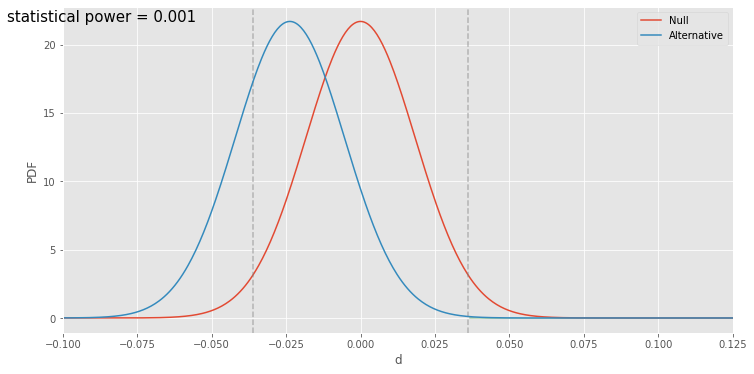

In [ ]:

abplot(N_A, N_B, bcr, d_hat, show_power = True)

### sample size vs. statistical power

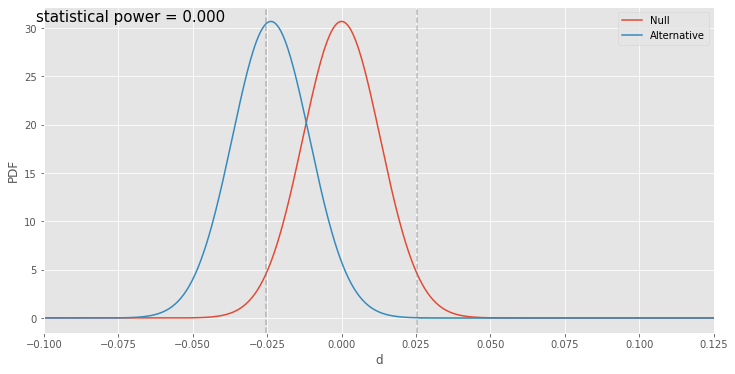

In [ ]:
abplot(2000, 2000, bcr, d_hat, show_power = True)

## Plot type I and type II error 

### Plot Type I error 

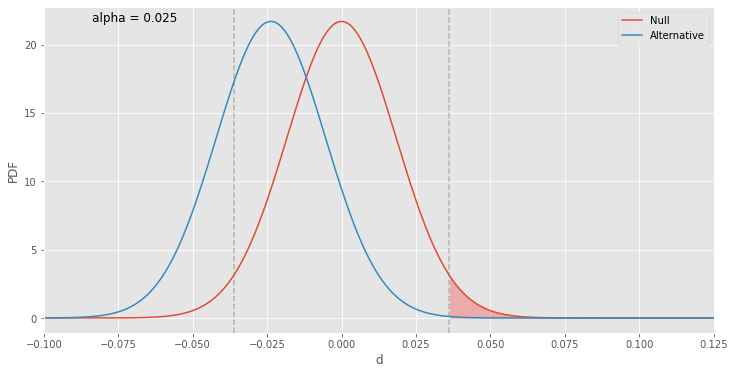

In [ ]:
abplot(N_A, N_B, bcr, d_hat, show_alpha = True)

### Plot Type II error 

In [ ]:
abplot(N_A, N_B, bcr, d_hat, show_beta = True)